In [44]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [45]:
from plot_lib import plot_data, plot_model, set_default

# Running the Models

In [1]:
# Load libraries
from sklearn.linear_model    import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble        import RandomForestRegressor as rfr,  GradientBoostingRegressor
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler
from sklearn.base            import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics         import mean_squared_error

In [2]:
## Load data
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
test = pd.read_csv('test.csv')
test_ID = test['Id']

In [4]:
train   = pd.read_csv('train_cleaning.csv')
test    = pd.read_csv('test_cleaning.csv')
y_train = pd.read_csv('y_train.csv')

In [5]:
y_train = y_train.values.ravel()

In [6]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
X_train, X_test, Y_train, Y_test = train_test_split(train, y_train, test_size=0.3, random_state=42)

# X_train = predictor features for estimation dataset
# X_test = predictor variables for validation dataset
# Y_train = target variable for the estimation dataset
# Y_test = target variable for the estimation dataset

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1020, 252) 
X_test:  (438, 252) 
Y_train:  (1020,) 
Y_test:  (438,)


Got this from a kaggler- it's pretty handy, letting us select the number of folds and letting us shuffle the data when we run it

In [7]:
n_folds = 10
#this looks better, lets me use kfolds
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Lasso was the first feature that I spotchecked all my changes against- It runs very quickly so it's easy to iterate off of.

In [8]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.00099, random_state=1))

In [9]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.1156 (0.0132)


In [10]:
lasso.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.00099, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [11]:
x = list(zip(train.columns, lasso.steps[1][1].coef_))
x.sort(key = lambda x: x[1])
df = pd.DataFrame(x, columns=['Var', 'Coeff'])

top_pos = df["Coeff"][-20:]
top_neg = df["Coeff"][:20]
top_pos_names = df["Var"][-20:]
top_neg_names = df["Var"][:20]

top_coefs = np.hstack([top_neg, top_pos])
top_names = np.hstack([top_neg_names, top_pos_names])

([<matplotlib.axis.XTick at 0x7f46602522b0>,
 <a list of 40 Text xticklabel objects>)

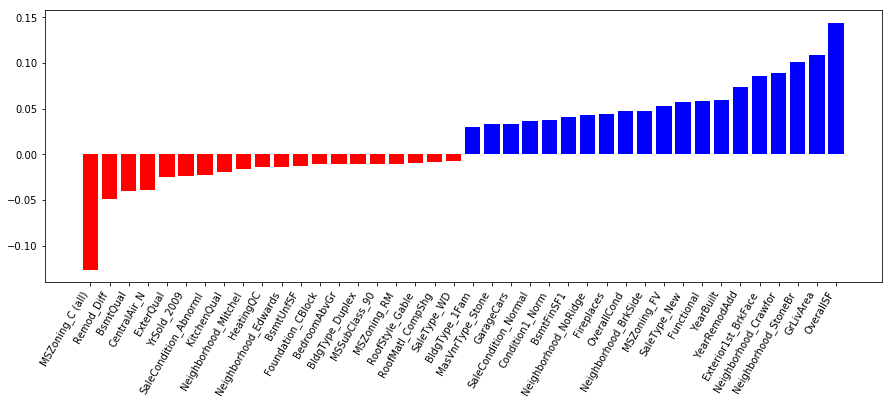

In [12]:
plt.figure(figsize = (15, 5))
colors = ['red' if c < 0 else 'blue' for c in top_coefs]
plt.bar(np.arange(40), top_coefs, color = colors)
feature_names = np.array(train.columns)
plt.xticks(np.arange(40), top_names, rotation = 60, ha = 'right')

switched away from boxcox to log1p and instantly improved by over 10%

ENet ended up being our best individual performer before we switched to stacking.  

In [13]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=1))

In [14]:
#ok so alpha here is the tuning parameter- L1 ratio is the % of penalty assigned to L1 or L2

In [15]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ElasticNet score: 0.1130 (0.0135)


In [16]:
ENet.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1, selection='cyclic', tol=0.0001, warm_start=False))])

In [17]:
x = list(zip(train.columns, ENet.steps[1][1].coef_))
x.sort(key = lambda x: x[1])
df = pd.DataFrame(x, columns=['Var', 'Coeff'])

top_pos = df["Coeff"][-20:]
top_neg = df["Coeff"][:20]
top_pos_names = df["Var"][-20:]
top_neg_names = df["Var"][:20]

top_coefs = np.hstack([top_neg, top_pos])
top_names = np.hstack([top_neg_names, top_pos_names])

([<matplotlib.axis.XTick at 0x7f466012db70>,
 <a list of 40 Text xticklabel objects>)

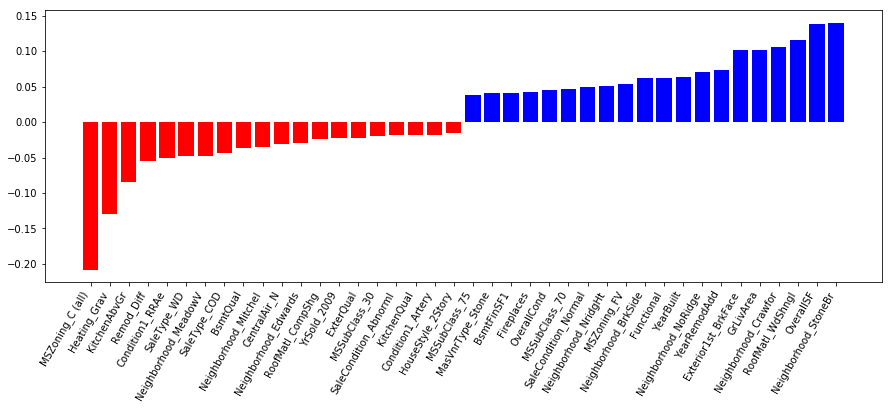

In [18]:
plt.figure(figsize = (15, 5))
colors = ['red' if c < 0 else 'blue' for c in top_coefs]
plt.bar(np.arange(40), top_coefs, color = colors)
feature_names = np.array(train.columns)
plt.xticks(np.arange(40), top_names, rotation = 60, ha = 'right')

- .9 l1_ratio gives score: 0.1098 (0.0145)
- .5  gives ElasticNet score: 0.1108 (0.0144)
- .7 gives .1099 (0.0146)
- alpha=0.0003, l1_ratio=.9 gives score: 0.1107 (0.0145) # while better here it's worse in my actual score

In [19]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [20]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1147 (0.0156)



In [21]:
GBoost.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=5,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [22]:
index = np.argsort(GBoost.feature_importances_)
features = GBoost.feature_importances_[index]
features = features[-40:]
names = np.array(X_train)[index]
names = names[-40:0]

# # plot as bar chart
# plt.barh(np.arange(len(names)), features)
# plt.yticks(np.arange(len(names)) + .25, names)
# _ = plt.xlabel('Relative importance')

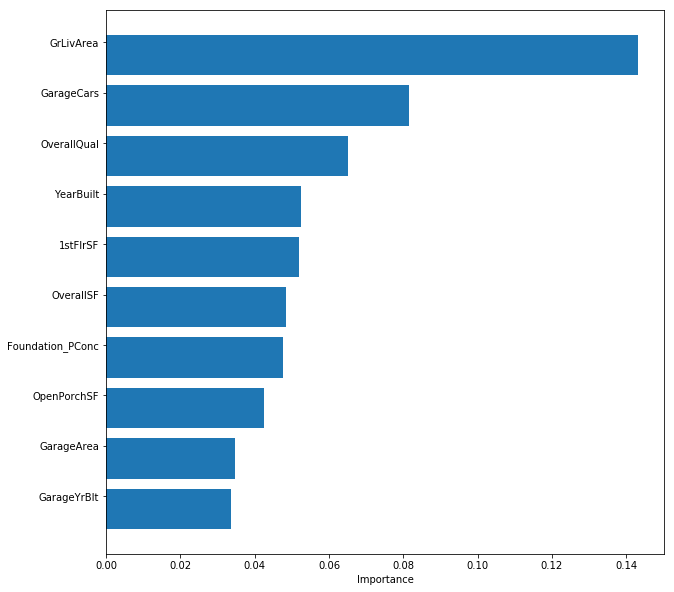

In [23]:
x = list(zip(train.columns, GBoost.feature_importances_))
x.sort(key = lambda x: x[1])
df = pd.DataFrame(x, columns = ['Var','Importance'])
top = df["Importance"][-10:]
top_name = df['Var'][-10:]
plt.figure(figsize = (10, 10))
plt.barh(np.arange(len(top_name)), top)
plt.yticks(np.arange(len(top_name))+ 0.25, np.array(top_name))
_ = plt.xlabel('Importance')

Kernel Ridge was another model I tried out but ended up tossing due to low starting scores- I didn't want to bother spending the time on a model that wasn't performing relatively well to begin with

In [24]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [25]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1185 (0.0134)



In [26]:
LGBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=2, max_features='sqrt',
                                    min_samples_leaf=15, min_samples_split=10,
                                    loss='huber', random_state =5)

In [27]:
score = rmsle_cv(LGBoost)
print("LGBoost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBoost score: 0.1139 (0.0148)



In [28]:
LGBoost.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=2,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             n_iter_no_change=None, presort='auto', random_state=5,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

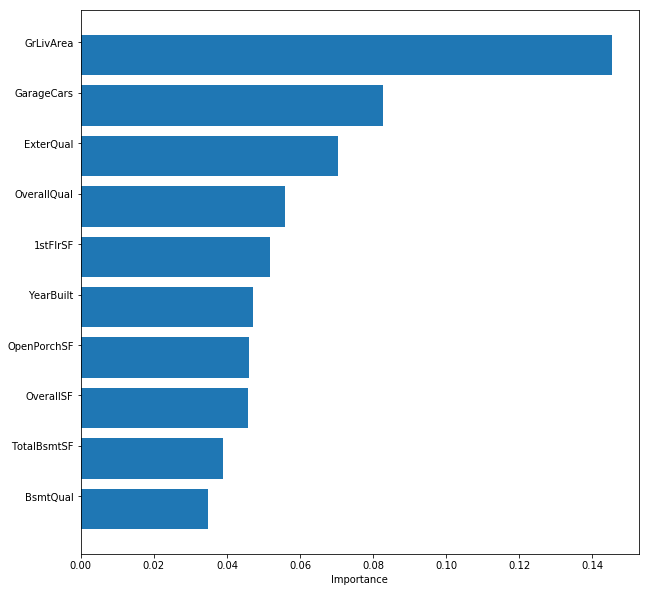

In [29]:
x = list(zip(train.columns, LGBoost.feature_importances_))
x.sort(key = lambda x: x[1])
df = pd.DataFrame(x, columns = ['Var','Importance'])
top = df["Importance"][-10:]
top_name = df['Var'][-10:]
plt.figure(figsize = (10, 10))
plt.barh(np.arange(len(top_name)), top)
plt.yticks(np.arange(len(top_name))+ 0.25, np.array(top_name))
_ = plt.xlabel('Importance')

Random forest- this one also underperformed out of the gate and also took relatively long to run compared to my linear models so I ended up discarding it instead of trying to tune it.

In [30]:
rfr = rfr(random_state=0,
        n_estimators=1000, max_depth=6,  max_features='sqrt')

In [31]:
score = rmsle_cv(rfr)
print("rfr score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

rfr score: 0.1609 (0.0153)



# Submitting the original models to kaggle

In [32]:
ENet.fit(train.values, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1, selection='cyclic', tol=0.0001, warm_start=False))])

In [33]:
final = ENet.predict(test)

In [34]:
results = np.exp(ENet.predict(test))
# results = np.expm1(ENet.predict(test))

In [35]:
attempt = pd.DataFrame()
attempt['Id'] = test_ID
attempt['SalePrice'] = results
attempt.to_csv('submit.csv', index=False)

# Ensembling by Averaging

the goal was to try and grab 2 random forest, 1 or 2 regression and 2 or 3 gbr. started with the models used in the kaggle jumpstart but liked my models better- discarded the random forest because it was underperforming compared to these other models

In [36]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    #cloning models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        #training the cloned models
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    #predicting based on the cloned models
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_])
        #averaging the predictions
        return np.mean(predictions, axis=1)

In [37]:
import random

def feature_importances(clf, X, y):
    score = np.mean(cross_val_score(clf, X,y,scoring='roc_auc'))
    importances = {} 
    for i in range(X.shape[1]):
        X_perm = X.copy()
        X_perm[:,i] = random.sample(X[:,i].tolist(), X.shape[0])
        perm_score = np.mean(cross_val_score(clf, X_perm , y, scoring='roc_auc'))
        importances[i] = score - perm_score

    return importances

In [38]:
averaged_models = AveragingModels(models = (ENet, GBoost, lasso, LGBoost))

In [39]:
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1085 (0.0142)



In [40]:
averaged_models.fit(train.values, y_train)

AveragingModels(models=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False...      subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)))

In [41]:
finalstack = averaged_models.predict(test)

In [42]:
resultstack = np.exp(averaged_models.predict(test))
# resultstack = np.expm1(averaged_models.predict(test))

In [43]:
attempt = pd.DataFrame()
attempt['Id'] = test_ID
attempt['SalePrice'] = resultstack
attempt.to_csv('stacksubmit.csv', index=False)